In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [3]:
np.random.seed(0)
torch.manual_seed(0)


In [6]:
import torch
import numpy as np
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

COMPANY_TICKER = "^FTSE"
TRAIN_SPLIT = 0.85

# data loader dates
START_DATE = "2000-01-01"
END_DATE = "2023-09-01"

EPOCHES = 5
LEARNING_RATE = 0.8
HIDDEN_LAYERS = 64
WINDOW_SIZE = 2


def normalize(train_data, test_data, plot=False):
    # normalizes the data in separate windows to allow lower price periods to still have a significance
    normalize_window = 2000
    scaler = MinMaxScaler()
    for i in range(0, len(train_data), normalize_window):
        train_data[i:i+normalize_window,
                   :] = scaler.fit_transform(train_data[i:i+normalize_window, :])
    # apply the normalized transformation to the test data afterwards
    test_data = scaler.transform(test_data)


    return train_data.reshape(-1), test_data.reshape(-1)


def train_test_split(prices, currency, plot=False):
    train_size = int(np.round(TRAIN_SPLIT * len(prices)))
    train_data = prices[:train_size].reshape(-1, 1)
    test_data = prices[train_size:].reshape(-1, 1)
    return train_data, test_data


def get_train_data_split(train_data):
    # splits out the train data into train_input and train_target
    train_windows = np.empty((len(train_data) - WINDOW_SIZE + 1, WINDOW_SIZE), dtype=np.float32)
    # fill train_windows using a sliding window across the train data
    for i in range(len(train_data) - WINDOW_SIZE + 1):
        train_windows[i] = train_data[i:i+WINDOW_SIZE]

    # all train windows but excludes the final price in each
    train_input = torch.from_numpy(train_windows[:, :-1]).reshape(-1, WINDOW_SIZE-1, 1)
    # all train windows but excludes the first price in each, corresponding to the next timestep in the sequence
    train_target = torch.from_numpy(train_windows[:, 1:]).reshape(-1, WINDOW_SIZE-1, 1)

    return train_input, train_target


def get_test_data_split(test_data):
    # splits out the test data into test_input and test_target
    test_prices = test_data.astype(np.float32)
    # makes predictions using the true test data windows
    test_windows = np.empty(
        (len(test_data) - WINDOW_SIZE + 1, WINDOW_SIZE), dtype=np.float32)
    for i in range(len(test_data) - WINDOW_SIZE + 1):
        test_windows[i] = test_data[i:i+WINDOW_SIZE]
    # all test window excluding the last point
    test_input = torch.from_numpy(test_windows[:, :-1]).reshape(-1, WINDOW_SIZE-1, 1)
    # all values after the first input window - equivalent to the last point of every test_input window
    test_target = torch.from_numpy(test_prices[WINDOW_SIZE-1:])
    return test_input, test_target


def load_data(start=START_DATE, end=END_DATE, plot=False):
    stock_df = yf.download(COMPANY_TICKER, start=start, end=end)
    currency = yf.Ticker(COMPANY_TICKER).info['currency']


    prices = stock_df['Adj Close'].values

    train_data, test_data = train_test_split(prices, currency, plot)
    train_data, test_data = normalize(train_data, test_data, plot)

    train_input, train_target = get_train_data_split(train_data)
    test_input, test_target = get_test_data_split(test_data)

    return train_input, train_target, test_input, test_target


In [7]:
train_input, train_target, test_input, test_target = load_data(plot=False)

[*********************100%***********************]  1 of 1 completed


In [11]:
print(train_input.shape)
print(test_input.shape)


torch.Size([5079, 1, 1])
torch.Size([895, 1, 1])


In [13]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        self.num_layers = num_layers

        # using dropout as a regularization technique to prevent overfitting
        self.lstm = nn.LSTM(1, self.hidden_layers, self.num_layers, batch_first=True, dropout=0.2)
        # self.gru = nn.GRU(1, self.hidden_layers, self.num_layers, batch_first=True, dropout=0.2) # gru

        self.linear = nn.Linear(self.hidden_layers, 1)

    def forward(self, input, future_preds=0):
        outputs = []
        h_t = torch.zeros(self.num_layers, input.size(0), self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(self.num_layers, input.size(0), self.hidden_layers, dtype=torch.float32)

        for input_t in input.split(1, dim=1):
            out, _ = self.lstm(input_t, (h_t, c_t))
            # out, _ = self.gru(input_t, h_t) # gru
            output = self.linear(out)
            outputs.append(output)

        # if future_preds then the model will make predictions using output as input
        for _ in range(future_preds):
            out, _ = self.lstm(output, (h_t, c_t))
            # out, _ = self.gru(output, h_t) # gru
            output = self.linear(out)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [14]:
model = LSTM(hidden_layers=HIDDEN_LAYERS)
criterion = nn.MSELoss()
# LBFGS optimizer since it can load the whole data for training
optimizer = optim.LBFGS(model.parameters(), lr=LEARNING_RATE)

def closure():
    optimizer.zero_grad()
    out = model(train_input)
    train_loss = criterion(out, train_target)
    print(f'train loss: {train_loss.item()}')
    train_loss.backward()
    return train_loss

for step in range(EPOCHES):
    optimizer.step(closure)


train loss: 0.5718238949775696
train loss: 0.38777145743370056
train loss: 0.06635089218616486
train loss: 0.054423242807388306
train loss: 0.0539950355887413
train loss: 0.05397062748670578
train loss: 0.05397036299109459
train loss: 0.05394226312637329
train loss: 0.05386185646057129
train loss: 0.053739044815301895
train loss: 0.053266532719135284
train loss: 0.05249803513288498
train loss: 0.049378592520952225
train loss: 8639.3720703125
train loss: 10.553763389587402
train loss: 4.991523742675781
train loss: 3.0685720443725586
train loss: 1.0702064037322998
train loss: 0.38858506083488464
train loss: 0.14083139598369598
train loss: 0.06966590136289597
train loss: 0.030048707500100136
train loss: 0.019398130476474762
train loss: 0.01537100039422512
train loss: 0.01495746336877346
train loss: 0.013214369304478168
train loss: 0.010852453298866749
train loss: 0.007300846744328737
train loss: 0.0041245948523283005
train loss: 0.0032403881195932627
train loss: 0.0024747734423726797
trai

In [15]:
def predict_next_point(test_input, test_target, model, criterion):
    # predicts the next point for each test data sliding window, only using test data as input
    prediction = model(test_input)
    # the prediction is all the last values for every predicted sliding window
    prediction = prediction[:, -1].reshape(-1)
    test_loss = criterion(prediction, test_target)
    print('test loss:', test_loss.item())
    prediction = prediction.detach().numpy()
    return prediction

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
FIGURE_SIZE = (13, 8)
def plot_predictions(prediction, test_target, show=False):
    plt.figure(figsize=FIGURE_SIZE)
    plt.title(f'{PREDICTION_TYPE} {COMPANY_TICKER} results')
    plt.plot(test_target.detach().numpy(), label='Test data')
    plt.plot(prediction, label='Prediction')
    plt.legend()
    plt.show()

test loss: 0.0016223154962062836


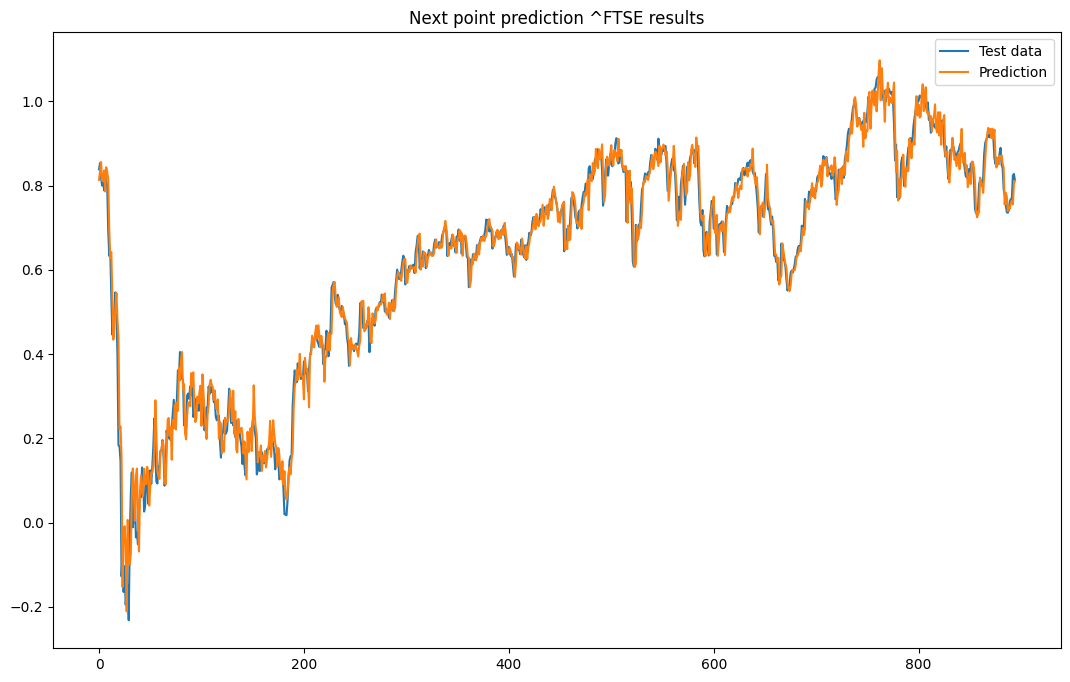

In [16]:
prediction = predict_next_point(test_input, test_target, model, criterion)
plot_predictions(prediction, test_target)